# Tutorial notebook for regression on extreme covariates

Implements and illustrates the methodology and theory developed in

    * Huet, N., Clémençon, S., & Sabourin, A. (2023). On regression in extreme regions. arXiv preprint arXiv:2303.03084.

    * Aghbalou, A., Bertail, P., Portier, F., & Sabourin, A. (2024). Cross-validation on extreme regions. Extremes, 27(4), 505-555.

## Table of Contents
* [Preliminary manipulations](#Preliminary)
* [Data generation](#Data_generation)
* [Choice of k, Episode 1.](#Choice_k_1)
* [Learning, prediction, evaluation](#Learning)
* [Choice of k: Episode 2, cross-validation](#Choice_k_2)
* [Conclusion](#conclusion)
* [Nonstandard covariates: rank-transformation ](#nonstandard)

## Preliminary manipulations <a class="anchor" id="Preliminary"></a>

In [3]:
# Set working directory if necessary
import os
os.getcwd()
#os.chdir("../")



'/home/anne/Dropbox/RECHERCHE/CODE/MLExtreme'

Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# #from sklearn.neural_network import MLPRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pareto
from copy import deepcopy
import MLExtreme as mlx



Choose a norm function according to which 'extreme' covariates will be
selected

In [5]:
def norm_func(x):
    return np.linalg.norm(x, ord=2, axis=1)

## Data generation <a id="Data_generation"></a>

Simple additive model

**N.B.**  The assumptions for regular variation w.r.t. the covariate  (see Huet et al.)
are  satisfied.

In [6]:
# sample size and dimension
n = 20000
Dim = 2

# Generating covariates X and covariates y
np.random.seed(42)
np.random.seed(42)
alpha = 2
X = mlx.gen_rv_dirimix(alpha,  Mu=np.array([[0.5,  0.5]]),
                       wei=np.array([1]), lnu=np.array([1]),
                       size=n)
# many other choices are possible, e.g
# alpha_dep = 0.7
# X = mlx.gen_multilog(n,Dim,alpha_dep)**(1/4)
y = mlx.gen_target_CovariateRV(X, param_decay_fun=2*alpha)

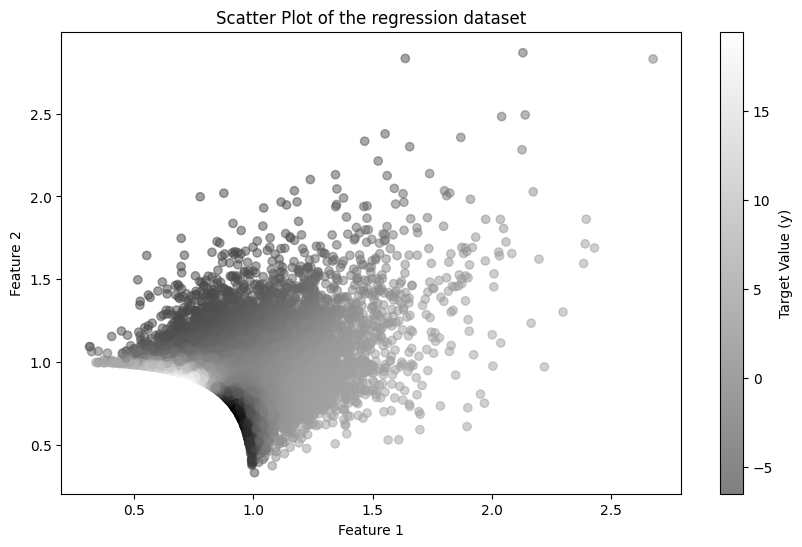

In [7]:
# Vizualisation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0]**(1/4), X[:, 1]**(1/4), c=y, cmap='gray', alpha=0.5)
# NB: exponent 1/4 above is meant to help visualization only. may be removed.
colorbar = plt.colorbar(scatter)
colorbar.set_label('Target Value (y)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of the regression dataset')
plt.show()

In [8]:
# Splitting the data into training and test sets
split = 0.5
n_train = n * (1-split)
# n_test = n * split 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split,
                                                    random_state=42)

## Choice of k, Episode 1. <a class="anchor" id="Choice_k_1"></a>

(For adaptive choice of k_train by cross-validation, see Episode 2 below)

To choose `k_train' the number of extreme training samples at the training step,
we suggest the following rule of thumb:

Select k_train as the largest k such that a distance covariance test [1] cannot reject the null hypothesis that the radius is independent from the pair (Angle, covariate). For small values of k, the p-value is computed by a permutation test, as justified in spirit in [2].  To avoid instabilities due to lack of moments of the radial variable, a log-transformation is applied.

Computation of the test statistics and p-values relies on the `dcor' package
https://dcor.readthedocs.io/en/stable/installation.html

Assuming `k_train` is correctly chosen,  theoretical guarantees at the
prediction test  cover in principle any `thresh_predict` such that:

` thresh_predict > np.quantiles(norm_func(X_test), 1 -  k_train/n_train) `

References
---------

[1] Székely, G. J., Rizzo, M. L., & Bakirov, N. K. (2007). Measuring and testing dependence by correlation of distances.

[2] Wan, P., & Davis, R. A. (2019). Threshold selection for multivariate heavy-tailed data. Extremes, 22(1), 131-166.

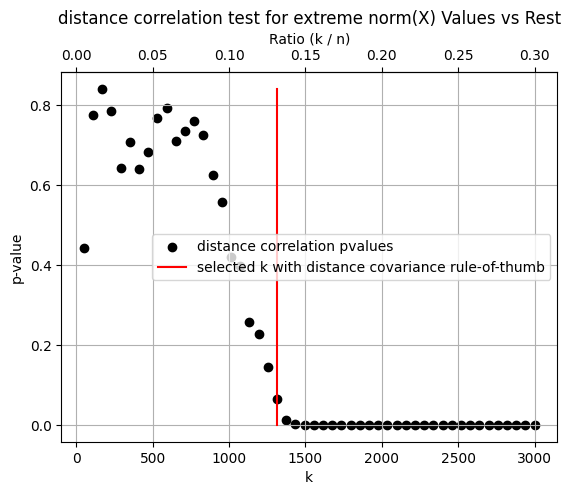

rule-of-thumb max admissible k: 1314, 
rule-of-thumb max admissible ratio of extremes: 0.13


In [9]:
ratios = np.linspace(50/n_train, 0.3, num=50)
pvalues, ratio_max = mlx.test_indep_radius_rest(X_train, y_train, ratios,
                                                norm_func)
# plot 
mlx.plot_indep_radius_rest(pvalues, ratios, ratio_max, n_train)
# k ~ 2000 maximum on this example.

k_max = int(ratio_max * n_train)

print(f'rule-of-thumb max admissible k: {k_max}, \n\
rule-of-thumb max admissible ratio of extremes: {mlx.round_signif(ratio_max, 2)}')
# indeed. 

In [10]:
# Set training and prediction ratios accordingly:
ratio_train = ratio_max * 4/5
ratio_test = ratio_max / 2   # higher quantile than training quantile: 
norm_X_train = norm_func(X_train)
thresh_predict = np.quantile(norm_X_train, 1-ratio_test)
k_train = int(ratio_train * n_train)
print(f'rule-of-thumb k_train: {k_train}')

rule-of-thumb k_train: 1051


## Learning, prediction, evaluation <a class="anchor" id="Learning"></a>

Choice of an off-the-shelf regression algorithm
see https://scikit-learn.org/stable/supervised_learning.html

In [11]:
# Pick a regression model in sklearn, previously imported
model = LinearRegression()  # RandomForestRegressor() #
# Regressor class initialization (basic model is hard copied in the constructor)
regressor = mlx.Regressor(model, norm_func)
naive = deepcopy(model)

# Model training
threshold, ratio, X_train_extreme = regressor.fit(X_train,  y_train,
                                                  k=k_train)
naive.fit(X_train, y_train)
# predict above a larger threshold (extrapolation)

# Prediction on the test data
y_pred_extreme,  X_test_extreme, mask_test = regressor.predict(
                                            X_test, thresh_predict)
y_pred_naive = naive.predict(X_test)
y_pred_naive_extreme = y_pred_naive[mask_test]

# mean_squared_error evaluation
y_test_extreme = y_test[mask_test]
mse = mean_squared_error(y_test_extreme, y_pred_extreme)
mse_naive = mean_squared_error(y_test_extreme, y_pred_naive_extreme)


mse_stdev = np.std((y_test_extreme - y_pred_extreme)**2) / \
    np.sqrt(len(y_test_extreme))
mse_naive_stdev = np.std((y_test_extreme - y_pred_naive_extreme)**2) / \
    np.sqrt(len(y_test_extreme))

print(f'mse (stdev) on extremes with rule-of-thumb k : \
{mlx.round_signif(mse, 2)} ({mlx.round_signif(mse_stdev, 2)}) ')
print(f'mse (stdev) on extremes with naive model : \
{mlx.round_signif(mse_naive, 2)} ({mlx.round_signif(mse_naive_stdev, 2)})')
print(f'mse constant predictor: {np.var(y_test_extreme):4f}')

mse (stdev) on extremes with rule-of-thumb k : 0.0018 (8.7e-05) 
mse (stdev) on extremes with naive model : 6.5 (0.26)
mse constant predictor: 9.584221


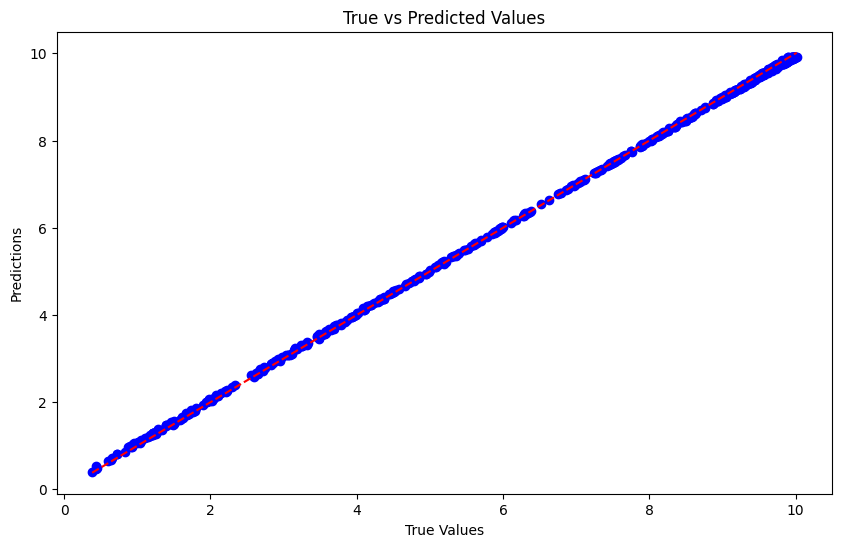

In [12]:
# Display regression results:
# MLX model:  
regressor.plot_predictions(y_test_extreme, y_pred_extreme)

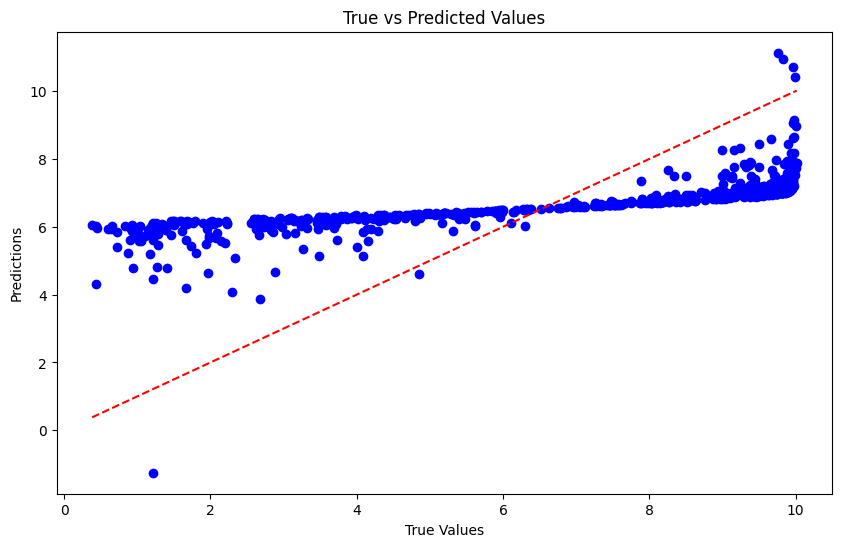

In [13]:
# Display regression results:
# Naive model:  
regressor.plot_predictions(y_test_extreme, y_pred_naive_extreme)

## Choice of k: Episode 2, cross-validation <a class="anchor" id="Choice_k_2"></a>

 `thresh_predict` is kept fixed as above (downstream task) `but thresh_train`
will be chosen by cross-validation

In [14]:
ratio_train_vect = np.geomspace(0.05, 0.15, num=10)
k_train_vect = (n_train * ratio_train_vect).astype(int)
thresh_train_vect = np.array([np.quantile(norm_X_train, 1 - r)
                              for r in ratio_train_vect])
kscores = []
kscores_sd = []
count = 1
# cv-loop (time consuming)
for thresh in thresh_train_vect:
    count+=1
    mean_scores, sd_mean_scores, _ = regressor.cross_validate(
        X_train, y_train, thresh_train=thresh, thresh_predict=thresh_predict,
        scoring=mean_squared_error,
        random_state=42 + 103*count)
    kscores.append(mean_scores)
    kscores_sd.append(sd_mean_scores)

kscores = np.array(kscores)
kscores_sd = np.array(kscores_sd)

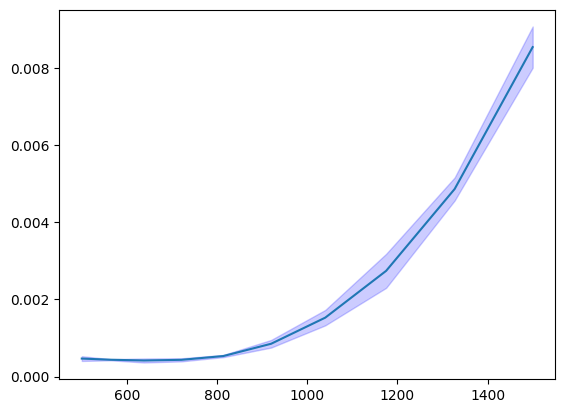

In [15]:
#  plot cv results
plt.plot(k_train_vect, kscores)
plt.fill_between(k_train_vect, kscores + 1.64 * kscores_sd,
                 kscores - 1.64 * kscores_sd, color='blue', alpha=0.2)
plt.show()

In [16]:
i_opt = np.argmin(kscores)
k_opt = k_train_vect[i_opt]
print(f'optimal k selected by CV: {k_opt}')
print(f'rule-of-thumb  k selected independence test: {int(k_max * 4/5)}')

optimal k selected by CV: 638
rule-of-thumb  k selected independence test: 1051


Checking that CV-choice of k indeed improves performance:
retrainig the model with the value `k_opt` obtained obove 

In [17]:
# Model training
# model_cv = RandomForestRegressor() 
# regressor = mlx.Regressor(model_cv, norm_func)
threshold, ratio, X_train_extreme = regressor.fit(X_train,  y_train,
                                                  k=k_opt)
# Prediction on the test data
y_pred_extreme_cv,  X_test_extreme, _ = regressor.predict(
                                            X_test, thresh_predict)

# mean_squared_error evaluation
y_test_extreme = y_test[mask_test]
mse_cv = mean_squared_error(y_test_extreme, y_pred_extreme_cv)
mse_cv_stdev = np.std((y_test_extreme - y_pred_extreme_cv)**2) / \
    np.sqrt(len(y_test_extreme))

## Conclusion <a class="anchor" id="conclusion"></a>

Wrapping-up: let's compare the MSE's on extremes with

     1) rule-of-thumb choice of k

     2) Cross-validation choice of k

     3) Naive off-the-shelf ML approach

In [18]:
print(f'mse (stdev) after CV on extremes with selected k_opt: \
{mlx.round_signif(mse_cv, 2)} ({mlx.round_signif(mse_cv_stdev, 2)})')
print(f'mse (stdev) before CV on extremes with rule-of-thumb k : \
{mlx.round_signif(mse, 2)} ({mlx.round_signif(mse_stdev, 2)}) ')
print(f'mse (stdev) naive model (trained on full untransformed dataset) : \
{mlx.round_signif(mse_naive, 2)} ({mlx.round_signif(mse_naive_stdev, 2)}) ')

mse (stdev) after CV on extremes with selected k_opt: 0.00049 (2.9e-05)
mse (stdev) before CV on extremes with rule-of-thumb k : 0.0018 (8.7e-05) 
mse (stdev) naive model (trained on full untransformed dataset) : 6.5 (0.26) 


 MSE on extremes with Naive method is one order of magnitude higher
than MLX model with rule-of-thumb choice of k.

Also, here, CV improves performance over 'rule-of-thumb choice of k'
by one order of magnitude!  

##  Non-standard input. <a class="anchor" id="nonstandard"></a>

(Coordinates of X may have different regular variation indices,
or even not be regularly varying at all).

**N.B** To date (2025), rank-transformation in a regression setting
is not covered by the theory. Only the classification case is [1].

For pedagogical purpose here we transform one column of X. However the rank
transformation used below is insensitive to monotonic transformation so the
results would be unchanged without this preliminary transformation.

[1] Clémençon, S., Jalalzai, H., Lhaut, S., Sabourin, A., & Segers, J. (2023). Concentration bounds for the empirical angular measure with statistical learning applications. Bernoulli, 29(4), 2797-2827.

In [19]:
# Arbitrary  (nonlinear) transformation of one component of the input
# the result in now considered as 'raw data'
X_raw = np.copy(X)
X_raw[:, 0] = np.log(1 + X[:, 0])
# Splitting the raw data into training and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw,  y,
                                                            test_size=split,
                                                            random_state=42)

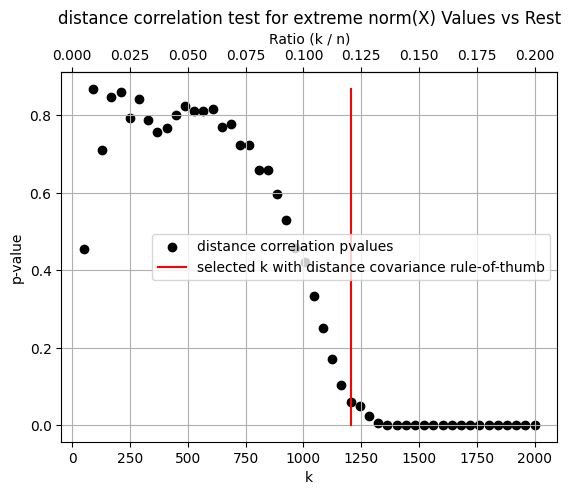

In [20]:
# rank-transform the training input into unit Pareto margins
X_train_rt = mlx.rank_transform(X_train_raw)
# learn the rank transformation on X_train and apply it to X_test
X_test_rt = mlx.rank_transform_test(x_train=X_train_raw, x_test=X_test_raw)
# Rule-of-thumb choice of k
ratios = np.linspace(50/n_train, 0.2, num=50) 
pvalues_rt, ratio_max_rt = mlx.test_indep_radius_rest(X_train_rt, y_train,
                                                      ratios,
                                                      norm_func) 
mlx.plot_indep_radius_rest(pvalues_rt, ratios, ratio_max_rt, n_train)

In [21]:
k_max_rt = int(ratio_max_rt * n_train)
# new rule-of-thumb k_max_rt: 
print(k_max_rt, mlx.round_signif(ratio_max_rt, 2))
# previously (with standard data): 
print(k_max, mlx.round_signif(ratio_max, 2))
# very similar 

1204 0.12
1314 0.13


In [22]:
# Set training and predictio ratios accordingly:
ratio_train = ratio_max_rt * 4/5
ratio_test = ratio_max_rt / 2  # higher quantile than training quantile: 
norm_X_train = norm_func(X_train_rt)
thresh_predict = np.quantile(norm_X_train, 1-ratio_test)
thresh_train = np.quantile(norm_X_train, 1-ratio_test)
k_train = int(ratio_train * n_train)
print(k_train, thresh_train)

963 28.856937453908408


In [23]:
# ### Learning on transformed inputs
# Classifier class initialization
# model_rt = RandomForestRegressor()
# regressor = mlx.Regressor(model_rt, norm_func)

# Model training on standardized data
threshold, ratio, _ = regressor.fit(X_train_rt, y_train, k=500)

# Prediction on the standardized test data
y_pred_extreme_rt, _ , mask_test_rt = regressor.predict(
                                            X_test_rt, thresh_predict)

# MSE  evaluation
y_test_extreme_rt = y_test[mask_test_rt]
mse_rt = mean_squared_error(y_test_extreme_rt, y_pred_extreme_rt)


# Comparison
print(f'mse (with rank transformation): {mse_rt:.6f}')
print(f'mse (without rank transformation): {mse:.4f}')
print(f'mse naive on extremes: {mse_naive:.4f}')
print(f'mse constant predictor: {np.var(y_test_extreme_rt):4f}')

mse (with rank transformation): 0.292876
mse (without rank transformation): 0.0018
mse naive on extremes: 6.4781
mse constant predictor: 10.368258


Performance deteriorates, but still beats Naive method.

**N.B.** The extreme train/test sets obtained with standardized data are a
priori different from the standard case. However the proportion of
disagreements is moderate:

In [24]:
print(f'Proportion of discordant selections of extremes on the test set: \n \
 {(np.sum(mask_test != mask_test_rt)/len(mask_test)):4f}')

Proportion of discordant selections of extremes on the test set: 
  0.006400
